# MOSELEY DATA

The previous notebook showed that it is possible for an MLP to learn decently the acoustic wave equation for one timestep. The goal of this notebook is to see if the first 10 timesteps can be approximated with an MLP. In the beginning the source term is not negligible, the last time step will act as the boudary loss for the PINN

In this model, the minibatch gradient descent is used instead of the full gradient descent simply because of computational power, the number of samples used for the training doesn't fit on the GPU

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

import warnings

warnings.filterwarnings("ignore")

In [24]:
# Pytorch Model Name
model_name = 'Moseley_Data_10_small_model.pt'

# Load Salvus data
path = "../../NoCrack/Simple_Homogeneous_Moseley/Event0000/output.h5"
hf = h5py.File(path, 'r')

In [4]:
# Test data
timestep = 40

df_test = pd.DataFrame()
df_test['X'] = hf['coordinates_ACOUSTIC'][:,0][:,0].astype(float)
df_test['Y'] = hf['coordinates_ACOUSTIC'][:,0][:,1].astype(float)
df_test['T'] = timestep * 0.002
df_test['True'] = hf['volume']['phi'][timestep][:,0].mean(axis=1)

In [5]:
# Training data
df_train = pd.DataFrame()

for ts in range(0,timestep+1,4):
    print('ts',ts)
    df_ts = pd.DataFrame()
    df_ts['X'] = hf['coordinates_ACOUSTIC'][:,0][:,0].astype(float)
    df_ts['Y'] = hf['coordinates_ACOUSTIC'][:,0][:,1].astype(float)
    df_ts['T'] = 0.002*ts
    df_ts['True'] = hf['volume']['phi'][ts][:,0].mean(axis=1)

    df_train = pd.concat((df_train,df_ts),axis=0)
df_train = df_train.reset_index(drop=True)

ts 0
ts 4
ts 8
ts 12
ts 16
ts 20
ts 24
ts 28
ts 32
ts 36
ts 40


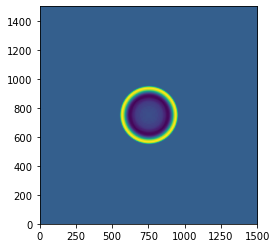

In [6]:
# Pivot Table to reorder the data
df_show = df_test.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False)

# Plot
plt.imshow(df_show.values,extent=[0,1500,0,1500])

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model import *
from model_wave_pinn import *
import pkbar

In [8]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
class dataset(Dataset):
    def __init__(self, inputs, outputs):
        super(Dataset, self).__init__()

        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return self.inputs.shape[0]
        
    def __getitem__(self, index):

        # X 
        X = self.inputs[index, :]

        y = self.outputs[index]
        return X, y

In [10]:
def plots(df_data):
    # Compute error :
    df_data['Error'] = df_data['Preds']-df_data['True']

    # Plot :
    fig, ax = plt.subplots(1,3,figsize=(16,4))

    im = ax[0].imshow(df_data.pivot_table(values='Preds',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[0].set_title('Prediction')
    fig.colorbar(im, ax=ax[0])

    im = ax[1].imshow(df_data.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[1].set_title('True')
    fig.colorbar(im, ax=ax[1])

    im = ax[2].imshow(df_data.pivot_table(values='Error',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[2].set_title('Error')
    fig.colorbar(im, ax=ax[2])

    plt.show()

In [22]:
model = Model(in_size=3,neurons_layer=10*[20], out_size=1)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 1e-5)

X_train = df_train.loc[:,['X','Y','T']].values
y_train = df_train.loc[:,['True']].values

In [23]:
# Epoch and batch size
epoch = 10
batch_size = 1000

train_dataset = dataset(X_train,y_train)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

model = model.to(device)

tot_loss = []

for e in range(epoch):
    model.train()

    epoch_loss = 0

    bar = pkbar.Pbar(name="Progress", target=int(train_dataset.__len__()/batch_size))

    for i, (X, true) in enumerate(trainloader):
        bar.update(i)

        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)

        true = torch.tensor(true).float().to(device)

        optimizer.zero_grad()

        preds = model(torch.cat([x, y, t], dim=1))

        loss = loss_fn(preds,true)

        loss.backward()

        optimizer.step()

        epoch_loss += loss

    tot_loss.append(epoch_loss)

    if e % 1 == 0:
       print('Iter %d, Loss: %.5e' % (e,epoch_loss))

Progress
990/990  [==============================] - 22.6s
Iter 0, Loss: 2.36501e+04
Progress
990/990  [==============================] - 23.4s
Iter 1, Loss: 2.36439e+04
Progress
990/990  [==============================] - 24.4s
Iter 2, Loss: 2.36087e+04
Progress
990/990  [==============================] - 25.3s
Iter 3, Loss: 2.35484e+04
Progress
990/990  [==============================] - 26.4s
Iter 4, Loss: 2.35223e+04
Progress
990/990  [==============================] - 26.8s
Iter 5, Loss: 2.35148e+04
Progress
990/990  [==============================] - 26.9s
Iter 6, Loss: 2.35124e+04
Progress
990/990  [==============================] - 31.5s
Iter 7, Loss: 2.35113e+04
Progress
990/990  [==============================] - 28.9s
Iter 8, Loss: 2.35106e+04
Progress
990/990  [==============================] - 28.7s
Iter 9, Loss: 2.35102e+04


In [25]:
# Save model
PATH = model_name

torch.save(model.state_dict(), PATH)

In [26]:
def prediction(model,X_test,y_test,device):

    model = model.to(device)
    x = torch.tensor(X_test[:, 0:1], requires_grad=True).float().to(device)
    y = torch.tensor(X_test[:, 1:2], requires_grad=True).float().to(device)
    t = torch.tensor(X_test[:, 2:3], requires_grad=True).float().to(device)

    true = torch.tensor(y_test).float().to(device)

    model.eval()
    with torch.no_grad():

        preds = model(torch.cat([x, y, t], dim=1))

    preds = preds.detach().cpu().numpy()
    return preds

In [28]:
# Load model
PATH = model_name

model_test = Model(in_size=3,neurons_layer=10*[20], out_size=1)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Model(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
)

In [29]:
X_test = df_test.loc[:,['X','Y','T']].values
y_test = df_test.loc[:,['True']].values

In [30]:
preds = prediction(model_test,X_test,y_test,device)

In [31]:
df_test['Preds'] = preds

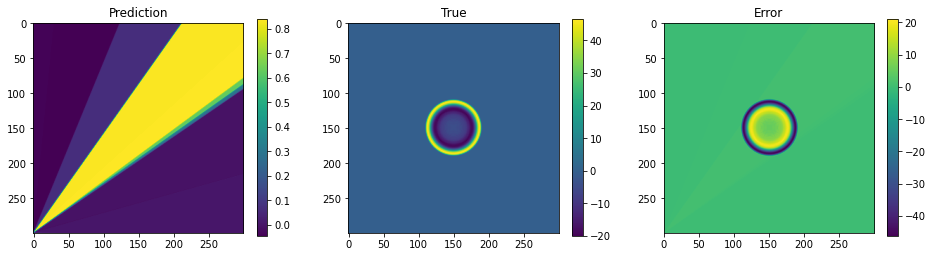

In [32]:
plots(df_test)